# Изучение архитектуры на основе LeNet в PyTorch. Осонвные операции сверточных нейронных сетей. 
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

https://huggingface.co/learn/computer-vision-course/
https://www.kaggle.com/learn/computer-vision
https://cs231n.github.io/
https://github.com/ahkarami/Great-Deep-Learning-Tutorials/blob/master/ComputerVision.md


## Импорт 

<!-- Как уже говорилось ранее модуль `torch.nn` содержит основные элементы для построения архитектур в рамках фреймворка `PyTorch`. 
Модуль предоставляет два типа API в классовом и процедурном стилях (подмодуль `torch.nn.functional`). В том числе модуль включает основные типы слоев нейронных сетей и основные функции активации и регуляризации.  -->

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [5]:
import torch.nn.functional as F
import torchvision
import torch
from torch import nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# LeNet архитектура

## Импорт torch

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

# from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [7]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:', torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:', torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d' % (n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device) / 1024 ** 3, 1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device) / 1024 ** 3, 1), 'GB')

    torch.set_default_dtype(dtype)  # float32
    print('default data type:', dtype)

    num_workers = os.cpu_count()
    print('available number of workers:', num_workers)

    return device, dtype, num_workers


#-------------------------------
def torch_seed(seed=42, deterministic=True):
    random.seed(seed)  # random and transforms
    np.random.seed(seed)  #numpy
    torch.manual_seed(seed)  #cpu
    torch.cuda.manual_seed(seed)  #gpu
    torch.backends.cudnn.deterministic = deterministic  #cudnn



In [8]:
device, dtype, num_workers = torch_stats()
torch_seed(seed=42, deterministic=True)

torch version: 2.5
Using device: cpu
default data type: torch.float32
available number of workers: 10


*Отметим, что от части данный урок вдохнавлен [этим](https://github.com/bentrevett/pytorch-image-classification) и [этим](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_convolutional-neural-networks/lenet.ipynb#scrollTo=FIGBGtQAyPIL) примерами.*

# Архитектура LeNet и ее модификации

В данном уроке мы рассмотрим методы описания архитектур нейронных сетей на примере архитектуры `LeNet`. Данная архитектура была одной из первых удачных попыток создания сверточных нейронных  сетей. Большенство подходов, использованных при создании архитектуры `LeNet` используются и сегодня, однако, не все. Поэтому мы реализуем адаптированный вариант `LeNet`.

Иллюстрация архитектуры `LeNet` представлена на рисунке ниже.

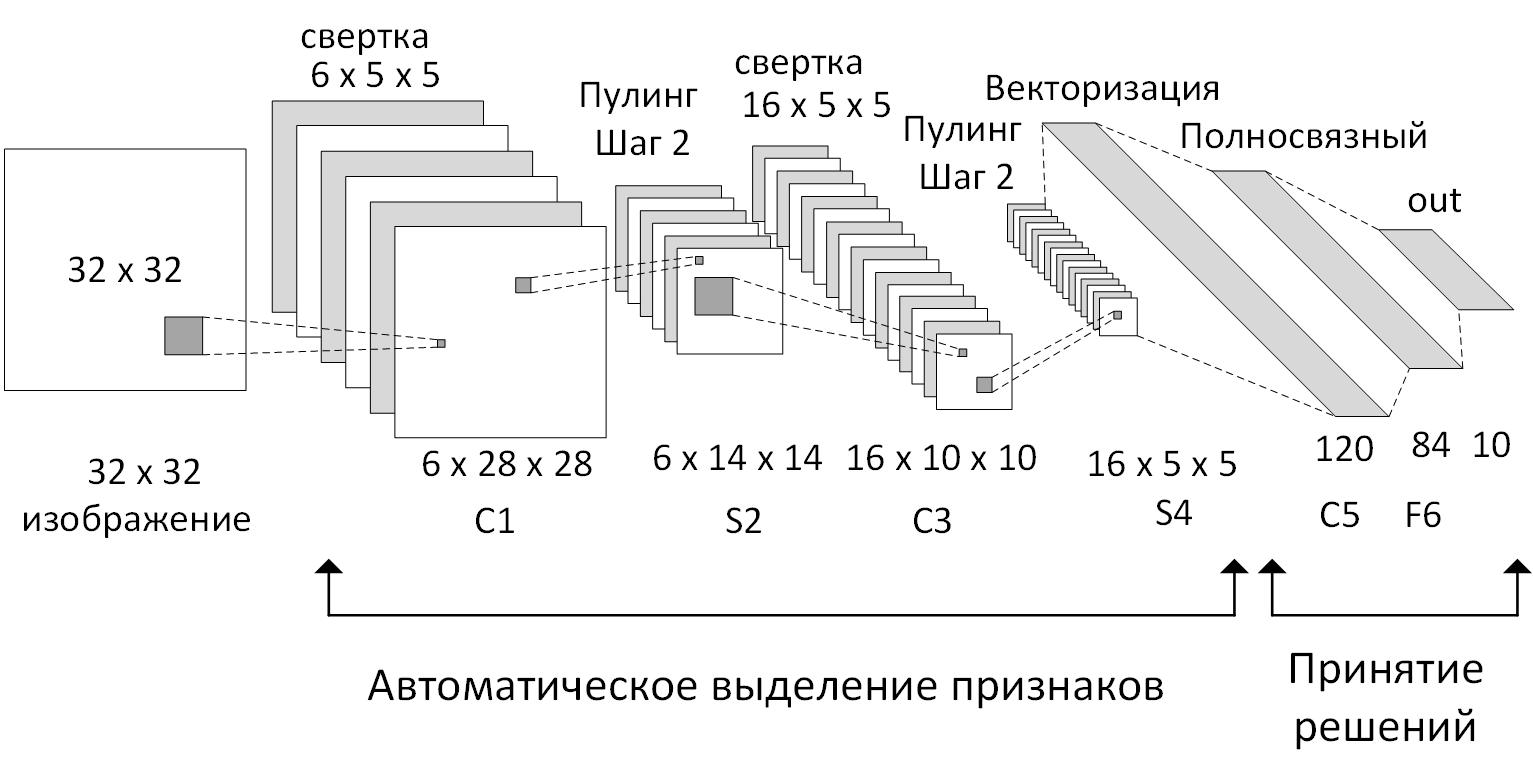
<!-- <img src="LeNet5.png" alt="LeNet5" title="LeNet5" width="650" />  -->

Для реализации архитектуры создадим класс, наследующий от `nn.Model`.

При описании архитектуры мы будем ориентироваться изображения размером $32\times 32$.

Каждый сверточный слой будет состоять из последовательности: *свертка*$\to$*активация*$\to$*пулинг*; каждый полносвязный слой будет состоять из *линейного слоя* и *активации*. Последний полносвязный слой должен иметь число выходов, равное числу классов. В нашем случае это будет $10$ классов. 

Сама архитектура сети должна быть описана в методе `forward`, который  должен иметь в качестве аргумента входной батч `x`. 

*Отметим*, что предпочтительно проводить инициализацию элементов архитектур нейронных сетей вне метода `forward`, в том числе в конструкторе класса `__init__`.



Таким образом архитектура `LeNet` имеет:
 * входной слой для изображений 32х32 (*число каналов*х32х32),
 * два сверточных слоя, 
 * каждый сверточный слой имеет также макс-пулинг субдискретизацию,
 * слой векторизации карты признаков (приобразования матрицы в вектор путем ее "разворачивания",
 * два полносвязных внутренних слоя,
 * выходной слой - слой классификации с 10 выходами.

Также особенности архитектуры:
* свертка валидная (с уменьшением размера карты признаков на размер ядра - 1)$^*$;
* ядро свертки имеет размер 5х5 (размер ядра = 5);
* макс-пулин выполняется с шагом 2 по тайлам 2х2;
* первый сверточный слой выдает 6 карт признаков 14х14 (после макс-пулинга);
* второй сверточный слой выдает 16 карт признаков 5х5 (после макс-пулинга);
* слой разворачивания принимает 16 карт признаков 5х5 и выдет вектор $1х16*5*5$ (1х400);
* первый полносвязный слой имеет 120 выходов (120 перцептронов);
* второй полносвязный слой имеет на выходе 84 перцептрона.

>$^*$Вобщем случае размер выхода свертки можно расчитать как: $$W=\frac{W−F+2P}{S}+1$$, где<ul>
    <li> $W$ входной размер, 
    <li> $F$ размер ядра свртки, 
    <li> $S$ шаг ядра,
    <li> $P$ паддинг. 

Реализуем сверточную сеть LeNet в виде класса

In [9]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes = n_classes

        # convolution
        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        # pooling
        self.pool = nn.AvgPool2d(kernel_size=2,
                                 stride=2)

        # classification
        self.fc1 = nn.Linear(in_features=16 * 5 * 5,
                             out_features=120)

        self.fc2 = nn.Linear(in_features=120,
                             out_features=84)

        self.fc_out = nn.Linear(in_features=84,
                                out_features=self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x  #torch.softmax(x, dim=1)

Отметим, что в силу простоты модели в общем случае ее можно было бы реализовать в контейнере `nn.Sequential`,
```python
model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84), 
            nn.Tanh(),
            nn.Linear(84, 10)
            )
```
Однако,
в более сложных моделях подход `nn.Sequential` окажется не столь удобным.

In [10]:
model = LeNet(3, 10)

# from torchsummary import summary
# summary(model, input_size=(1, 3, 32, 32))

Посмотрим также карту параметров

In [11]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0], '\t', params[idx][1].size())
print('\n', 10 * '--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters())
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc_out.weight 	 torch.Size([10, 84])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 62006
Number of all parameters for the model: 62006


Посмортим на выход сети в данный момент. 

In [12]:
X = torch.randn(1, 3, 32, 32)  # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[ 0.04255842 -0.02173552  0.06267481  0.01251069  0.13156408 -0.11375648
   0.10174079  0.0703436  -0.05295545  0.12774406]] 
 max position (Class index): 4


В данном примере мы рассмотрим набор данных `CIFAR 10`.

`Cifar10` - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер `32` на `32` пикслея (то есть представляет тензор размером `3х32х32`).

Например `Cifar10` содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Опишим набор преобразований. Мы будем использовать разные преобразования дл тестового и тренировочного наборов данных. В преобразованиях мы используем стандартную нормализацию яркости изображений, о которой речь шла в одном из предыдущих занятий.

In [15]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Resize(36),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

__Обратите внимание__, что часто рекомендуется после выполнения преобразований провести нормализацию `Normalize(mean, std)`. При этом заданные константы среднего и сдандартного отклонения определены эмпирически для достаточно крупных наборов данных.

Часто для трех-канальных (`RGB`) изображений рекомендуемые значения:
* $mean = [0.485, 0.456, 0.406]$ 
* $std = [0.229, 0.224, 0.225]$. 

Данные значения получены путем усреднения по набору данных `ImageNet2012`, разъяснение можно найти [тут](https://github.com/pytorch/vision/pull/1965) и [тут](https://github.com/pytorch/vision/issues/1439). 

* Для черно-белых изображений рекомендуемые значения $mean=[0.445]$ и $std=[0.2692]$.

Проведем загрузку набора данных. Для этого воспользуемся стандартным функционалом модуля `torchvision.datasets`. Загрузка будет происходить в два этапа: первый - тренеровочный набор данных, второй - тестовый. Для каждого набора данных задаим преобразования.

После загрузки наборов данных проверим какие классы в наборах представлены.

In [14]:
!pip3 install --upgrade certifi

In [15]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [16]:

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=test_transforms)

names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:', names_classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<blockquote>
    
Отметим, что также можно загрузить свой набор данных 
и также сделать свой класс для набора даннх вида 
```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
Также наборы данных могут быть загружены в некоторых стандатрных формах. Например, класс `ImageFolder` позволяет загружать набор данных в виде структуры: `директория датасата->(train, val, test)->директории по классам`. Подробную информацию можно найти в документации [тут](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) и в официальном примере [тут](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
    
Доступные наборы посмотреть данных в модуле `torchvision.datasets` можно посмотреть при помощи команды `print(torchvision.datasets.__all__)`. Документация по данному модулю может быть найдена [тут](https://pytorch.org/vision/stable/datasets.html). 

Выделим часть тренировочного набора данных в валидационный. Для этого воспользуемся встроенным методом `random_split`. Если вы используете `GPU` метод потребует указать соответствующий генератор случайных чисел, например `torch.Generator(device='cuda')`.

In [17]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [18]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Сами по себе созданные объекты `trainset, validset` и `testset` являются экземплярами класса `torch.utils.data.dataset.Subset`, который описывает наборы данных. 

Для того, чтобы получить из соответствующего класса данные в формате загрузчика `PyTorch` можно воспользоваться классом `DataLoader` из `torch.utils.data`. Данный класс представляет загрузчик мини-батчей (пакетов) данных. Для его использования укажем размер батча, а также установим флаг перемешивания данных для тренировочной части.

Важно отметить, что экземпляры класса `DataLoader` - являются итерируемыми объектами. Работа с таким объектами может осуществляться только в цикле. Также, для единичного вызова итерируемых объектов можно воспользоваться конструкцией вида `next(iter(data))`.

In [19]:
BATCH_SIZE = 256

trainloader = data.DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE)

validloader = data.DataLoader(validset, batch_size=BATCH_SIZE)

testloader = data.DataLoader(testset, batch_size=BATCH_SIZE)

В конструкторе класса `DataLoader` также важно отметить аргументы `num_workers`, `pin_memory` и `generator`. 
* Аргумент `num_workers` использует субпроцессы для асинхронной загрузки данных на `CPU`. Увеличение числа работников приводит к параллелизации загрузки и предобработки данных, однако слишьком большое число работников может привести к излишней загрузке памяти (ОЗУ) и даже может заторозить работу. Число работников по умолчанию 0 - это означает, что работа будет выполнена в главном процессе.
* Аргумент `pin_memory` позволяет  зарезервировать ОЗУ в `GPU` для ускорения операций загрузки в видеоускоритель.
* Аргумент генератор позволяет специфицировать метод выборки. В некоторых случаях, при использовании `GPU` рекомендуется использовать `generator=torch.Generator(device='cuda')`. Также отметим, что в тех же случаях не стоит одновременно задавать `generator`  и  `num_workers`.

Проверим работоспособность загручика данных

In [20]:
# get some random training images batch
dataiter = next(iter(trainloader))

# parse images and lables from batch
images, labels = dataiter

print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


Обратите внимание на размерность данных, тут сначала идет размер выборки (число объектов в батче), затем число каналов (у нас 3 канала), а затем размер каждого объекта. Таким орбазом каждый батч является 4-х мерным. Это важно понимать для последующей обработки данных вне фреймворка `PyTorch`.

Теперь попробуем визуализировать набор данных. Для этого мы напишим функцию `imshow`. Аргументами данной функции являются: батч (`images`), число изорбажений по вертикали (`nrow`), размер изображения (`figsize`), а также значения среднего и СКО, использовавшиеся для визуализации изображений. Последние нужны для восстоновление нормализованного изображения. 

В данной функии мы выполняетм транспонирование (перестановку размерностей) для входонго бата. Это необходимо для того, чтобы привести размерности к стандартному виду для `matplotlib`. 

Также отметим, что для визуализации изображений мы должны преобразовать их из формата `torch.tensor` в `numpy.ndarray`. Если тензор находится на `GPU` мы также должны отправить его обратно на `CPU`. Для совершения этих операций мы воспользуемся стандартным методом:
`img = img.data.cpu().numpy()`.


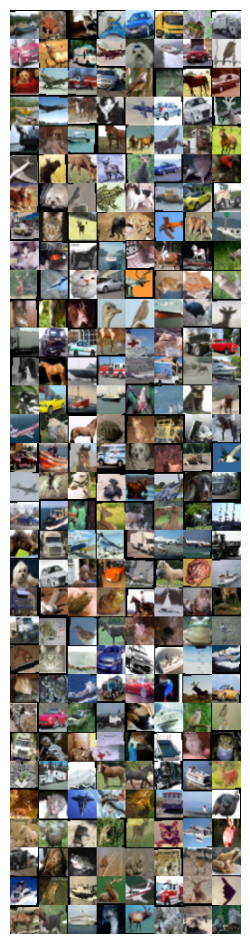

first raw classes  ship  frog   cat airplane automobile truck  frog truck automobile  deer truck airplane   dog  ship automobile  bird   dog airplane truck automobile  bird  deer horse automobile airplane airplane horse   cat airplane automobile automobile  deer
torch.Size([256, 3, 32, 32])


In [21]:
def imshow(images, nrow=8, figsize=(16, 12), mean=MEAN, std=STD):
    img = torchvision.utils.make_grid(images, nrow=nrow, padding=0).to(device)

    img = img.transpose(2, 0).transpose(0, 1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)  # unnormalize

    img = img.data.cpu().numpy()

    plt.figure(figsize=(16, 12))
    plt.imshow(img);
    plt.axis('off');
    plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes', ' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE // 8)))

print(images.shape)

Проведем инициализацию весовых параметров модели. Напомним, что для слоев с `ReLU` рекомендуется проводить инициализацию Кайменга Ге (`Kaiming He`) с нормальным распределением, а для слоев с сигмоидом инициализацию Хавьера Глора (`Xavier Glort`) с равномерным распределением. В нашем случа мы воспользуемся функцией `nn.init.kaiming_normal_`. Также проинциализируем смещения нулями для всех слоев.

In [22]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)


model.apply(init_weights);


Для оценки точности работы модели зададим функцию `accuracy`, которая будет подсчитывать число паравильных ответов `correct_cls` и сравнивать с числом ответов всего.

In [6]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Теперь зададим параметры обучения. Мы будем использовать `CrossEntropyLoss` в качестве функции потерь и оптимизацию методом `SGD with momentum` c фиксированной скоростью обучения (`LR`) и моментом $0.9$ - данное значение, как правило, рекомендуется по умолчанию.



In [24]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric = accuracy
model = model.to(device)
criterion = criterion.to(device)

Зададимся уже известными функциями `train` и `evaluate`

In [8]:
def train(model, dataloader, optimizer, criterion, metric, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [9]:
def evaluate(model, dataloader, criterion, metric, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc = metric(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [10]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Проведем тренировку на 20 эпохах. В ходе проведения тренировки будем контролровать лучшую эпоху проверяя ее loss на валидации. Каждые 2 эпохи будем выводить результат работы сети в текстовом виде.

Отметим, что желающие могут найти более развернутые примеры решения задачи классификации в разделе `references` официального репозитория `torchvision` [тут](https://github.com/pytorch/vision/tree/v0.8.2/references/classification).

In [28]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:  # print every 2 epochs:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 1.884 | Train Acc: 32.40%
	 Val. Loss: 1.792 |  Val. Acc: 37.28%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

KeyboardInterrupt: 

Теперь попробуем визуализировать процесс обучения.

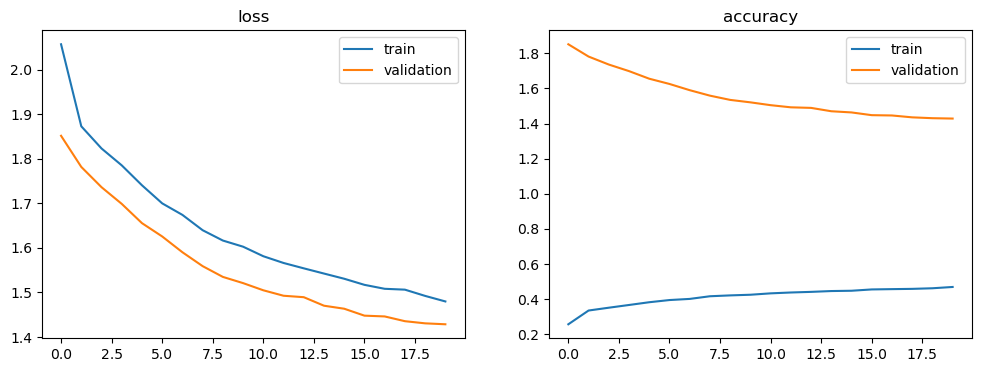

In [37]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(train_loss.cpu().numpy(), label='train')
    axs[0].plot(valid_loss.cpu().numpy(), label='validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label='train')
    axs[1].plot(valid_acc.cpu().numpy(), label='validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()


plot_results(train_loss, valid_loss, train_acc, valid_loss)

Проверим точность на лучшей эпохе для тестового набора данных.

In [38]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.411 | Test Acc: 49.10%


<!-- <blockquote>
    
Отметим, что процесс обучения может также быть дополнен некоторыми другими опциами. Так, например, процесс может быть дополнен классичесими <code>L1</code> и/или <code>L2</code> регуляризациями. Для использования общей <code>L2</code> регуляризации достаточно использовать вариант `SGD with weight_dacy` в виде:
```python
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9,weight_decay=1e-4 )
```
 -->

Теперь посмотрим на результаты точности по каждому классу  для тестового набора данных. 

Отметим, что в данной операции мы отдельно подсчитываем точность как отношение `class_correct` к `class_total` по каждому классу `label`, а  также собираем  классы для всех экземпляров `labels` и предсказания `predicts`.

In [39]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total = torch.zeros(n_classes)

labels = []
predicts = []

model.eval()

with torch.no_grad():
    for x, y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze()  # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        labels.append(y)
        predicts.append(cls_pred)

labels = torch.cat(labels, dim=0)  # make it 1d array
predicts = torch.cat(predicts, dim=0)  # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of airplane : 56 %
Accuracy of automobile : 72 %
Accuracy of  bird : 45 %
Accuracy of   cat : 30 %
Accuracy of  deer : 32 %
Accuracy of   dog : 34 %
Accuracy of  frog : 52 %
Accuracy of horse : 57 %
Accuracy of  ship : 62 %
Accuracy of truck : 50 %


В ряде случаев, также будет важным сохраненить результатов работы сети. Для этого может быть использован, например следующий код.

In [40]:
sorted_ids = list(range(1, n_samples + 1))

sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': predicts})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

Также построим т.н. `confusion_matrix` - матрицу, изображающую результаты предсказаний для каждого класса.

In [41]:
def plot_confusion_matrix(labels, pred_labels, names_classes):
    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(np.asarray(labels, dtype=int),
                          np.asarray(pred_labels, dtype=int))

    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)

    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

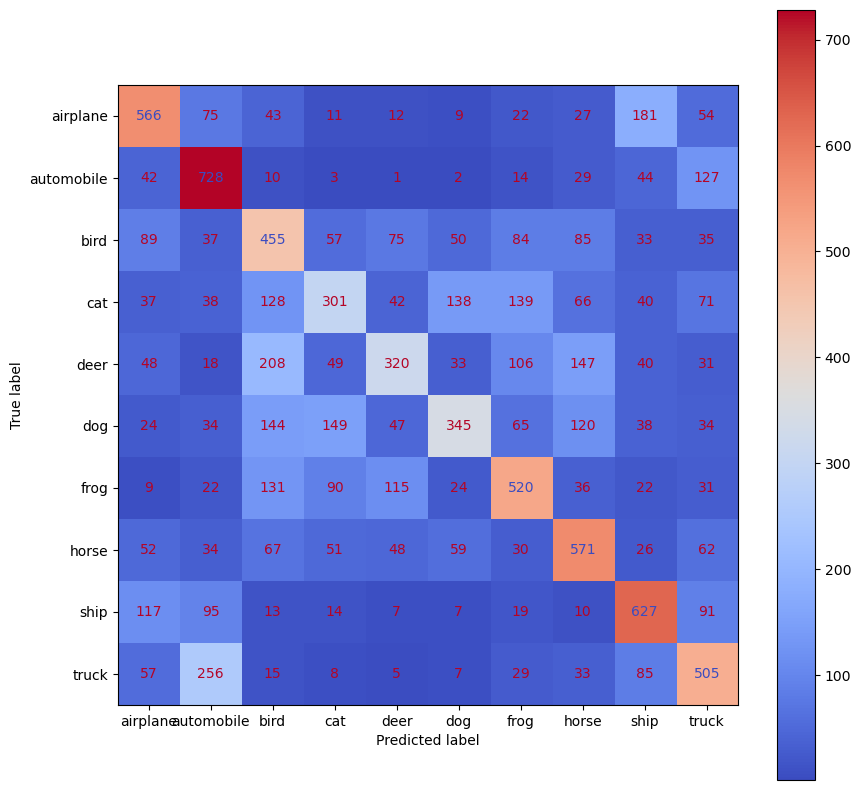

In [42]:
plot_confusion_matrix(labels, predicts, names_classes)

Отметим, также возможность для визуализации работы нейронной сети. Попробуем визуализировать карты признаков для фильтров первого слоя.

In [43]:
def plot_filtered_images(images, filters):
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    print(images.shape)

    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images):

        img = images[i].squeeze(0).numpy().transpose((1, 2, 0))

        img = 255 * (img - img.min()) / (img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters + 1, i + 1 + (i * n_filters))

        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            image = image.numpy().astype(float)

            image = 255 * (image - image.min()) / (image.max() - image.min())

            ax = fig.add_subplot(n_images, n_filters + 1, i + 1 + (i * n_filters) + j + 1)

            ax.imshow(image.astype(int), cmap='bwr')

            ax.set_title(f'Filter {j + 1}')
            ax.axis('off')
    return filtered_images

torch.Size([5, 3, 32, 32])


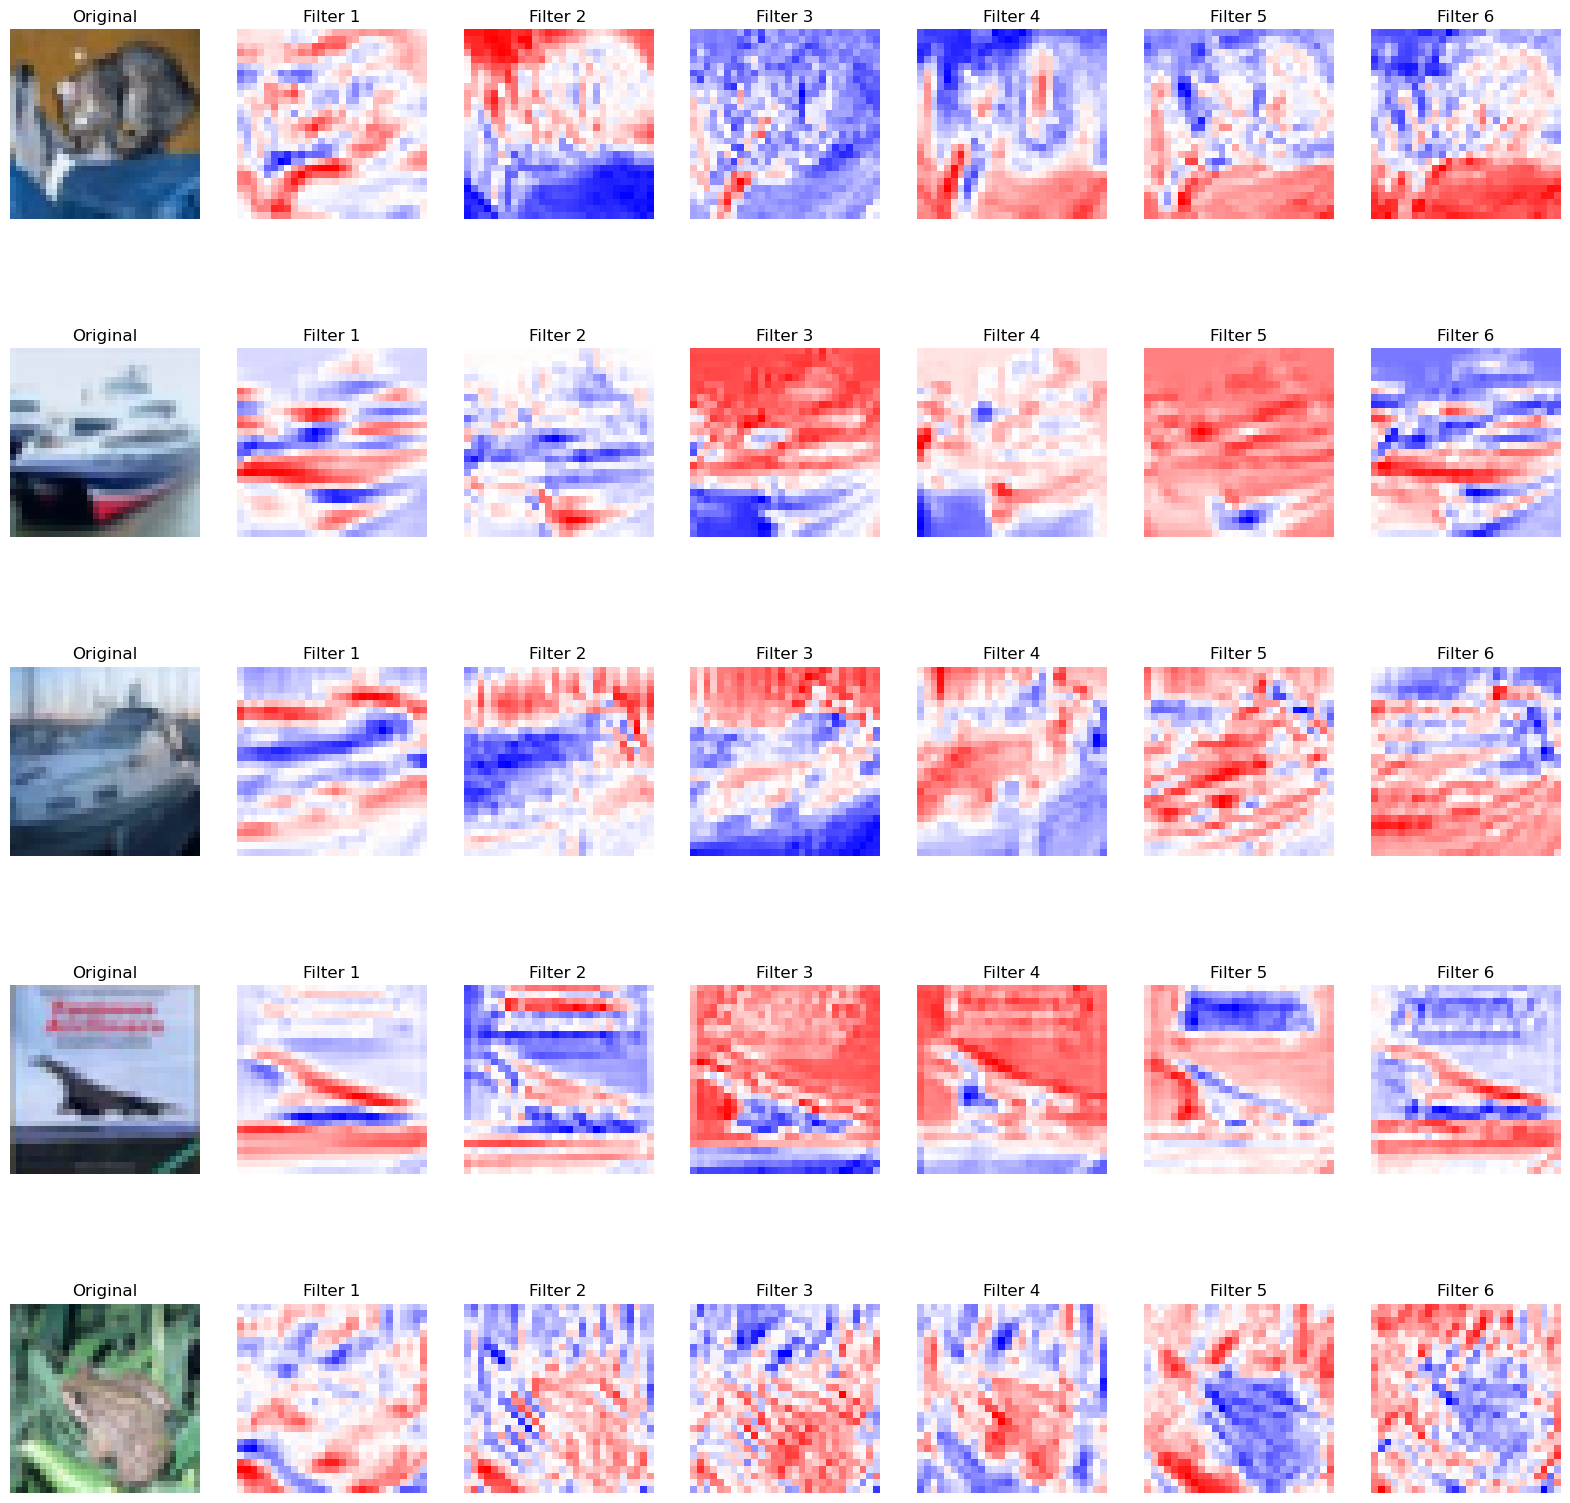

In [44]:
N_IMAGES = 5

images = [image for image, label in [testset[i] for i in range(N_IMAGES)]]

filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

## Задания

__1.__ Проверьте помогает ли для увеличения точности использование агументаци.

In [71]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

augmentation_train_transforms = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # Случайная обрезка
        transforms.RandomHorizontalFlip(),  # Горизонтальное отражение
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Цветовые изменения
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ],
)
augmentation_test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ],
)

In [73]:
augmentation_trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=augmentation_train_transforms,
)

augmentation_testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=augmentation_test_transforms,
)

names_classes = augmentation_trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:', names_classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [75]:
augmentation_model = LeNet(3, 10)
VALID_RATIO = 0.9
n_train_examples = int(len(augmentation_trainset) * VALID_RATIO)

n_valid_examples = len(augmentation_trainset) - n_train_examples

augmentation_trainset, augmentation_validset = data.random_split(augmentation_trainset,[n_train_examples, n_valid_examples])

augmentation_validset = copy.deepcopy(augmentation_validset)
augmentation_validset.dataset.transform = augmentation_test_transforms

In [76]:
BATCH_SIZE = 256

augmentation_trainloader = data.DataLoader(augmentation_trainset, shuffle=True, batch_size=BATCH_SIZE)
augmentation_validloader = data.DataLoader(augmentation_validset, batch_size=BATCH_SIZE)
augmentation_testloader  = data.DataLoader(augmentation_testset, batch_size=BATCH_SIZE)

In [77]:
augmentation_model.apply(init_weights)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_out): Linear(in_features=84, out_features=10, bias=True)
)

In [78]:
LR = 0.003

device = "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmentation_model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
augmentation_model     = augmentation_model.to(device)
criterion = criterion.to(device)

In [80]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(augmentation_model,
                                                augmentation_trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(augmentation_model,
                                                   augmentation_validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(augmentation_model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:  # print every 2 epochs:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 1.887 | Train Acc: 32.58%
	 Val. Loss: 1.812 |  Val. Acc: 36.17%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 1.809 | Train Acc: 35.78%
	 Val. Loss: 1.731 |  Val. Acc: 38.27%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 1.745 | Train Acc: 37.54%
	 Val. Loss: 1.653 |  Val. Acc: 41.26%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 1.672 | Train Acc: 39.84%
	 Val. Loss: 1.578 |  Val. Acc: 43.20%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 1.622 | Train Acc: 41.61%
	 Val. Loss: 1.524 |  Val. Acc: 44.76%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 15s
	Train Loss: 1.583 | Train Acc: 43.02%
	 Val. Loss: 1.488 |  Val. Acc: 45.60%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 15s
	Train Loss: 1.542 | Train Acc: 44.53%
	 Val. Loss: 1.443 |  Val. Acc: 47.27%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 15s
	Train Loss: 1.520 | Train Acc: 45.19%
	 Val. Loss: 1.410 |  Val. Acc: 49.11%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 14s
	Train Loss: 1.487 | Train Acc: 46.44%
	 Val. Loss: 1.374 |  Val. Acc: 49.78%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 16s
	Train Loss: 1.469 | Train Acc: 47.25%
	 Val. Loss: 1.345 |  Val. Acc: 51.41%


In [83]:
n_classes = 10
n_samples = len(augmentation_testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

augmentation_model.eval()

with torch.no_grad():

    for x,y in tqdm(augmentation_testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = augmentation_model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of airplane : 57 %
Accuracy of automobile : 67 %
Accuracy of  bird : 37 %
Accuracy of   cat : 41 %
Accuracy of  deer : 42 %
Accuracy of   dog : 38 %
Accuracy of  frog : 63 %
Accuracy of horse : 59 %
Accuracy of  ship : 60 %
Accuracy of truck : 47 %


Показатели обучения на исходной тестовой
выборке без аугментации
![](photo_2024-12-02%2021.40.16.jpeg)

__2.__ Наиболее "тяжелые" слои  в сверточных нейронных сетях - это полносвязные слои принятия решений.  В оригинальной архитектуре их два. __Проверьте__ на сколько снижается точность и объем параметров, если убрать один полносвязный слой из архитектуры LeNet.

In [81]:
class LeNetWithoutFC2(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)


        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2,
                                 stride      = 2)

        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5,
                             out_features = 84)

        # self.fc2 = nn.Linear(in_features  = 120,
        #                      out_features = 84)

        self.fc_out = nn.Linear(in_features = 84,
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        # x = self.fc2(x)
        # x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x  # torch.softmax(x, dim=1)

In [82]:
model_without_fc2 = LeNetWithoutFC2(in_channels=3, n_classes=10)

In [84]:
total_params_new = sum(p.numel() for p in model_without_fc2.parameters())
trainable_params_new = sum(p.numel() for p in model_without_fc2.parameters() if p.requires_grad)
total_params_old = sum(p.numel() for p in model.parameters())
trainable_params_old = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Общее количество параметров новой модели: {total_params_new}")
print(f"Количество обучаемых параметров новой модели: {trainable_params_new}")
print(f"Общее количество параметров старой модели: {total_params_old}")
print(f"Количество обучаемых параметров старой модели: {trainable_params_old}")

Общее количество параметров новой модели: 37406
Количество обучаемых параметров новой модели: 37406
Общее количество параметров старой модели: 62006
Количество обучаемых параметров старой модели: 62006


In [85]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model_without_fc2,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model_without_fc2,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model_without_fc2.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:  # print every 2 epochs:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 2.305 | Train Acc: 10.17%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 2.305 | Train Acc: 10.07%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 2.305 | Train Acc: 10.17%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 2.305 | Train Acc: 10.27%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 2.305 | Train Acc: 10.14%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 16s
	Train Loss: 2.305 | Train Acc: 10.21%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 14s
	Train Loss: 2.305 | Train Acc: 10.15%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 12s
	Train Loss: 2.305 | Train Acc: 10.15%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 12s
	Train Loss: 2.305 | Train Acc: 10.24%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 13s
	Train Loss: 2.305 | Train Acc: 10.21%
	 Val. Loss: 2.304 |  Val. Acc: 10.24%


In [86]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model_without_fc2.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model_without_fc2.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of airplane : 86 %
Accuracy of automobile :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  3 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 12 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


__3.__ В Оригинальной работы Лекуна использовался средний пулинг и функции активации вида $f(x)=tanh(x)+\alpha\cdot x$, где $\alpha<<1$ и оптимизатор `SGD with momentum`. Проверьте точность архитектуры если заменить средний пулинг на максимальный, если использовать определение точности по Лекуну. 

In [9]:
class LeNetLekun(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes = n_classes

        # convolution
        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        # max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # classification
        self.fc1 = nn.Linear(in_features=16 * 5 * 5,
                             out_features=120)

        self.fc2 = nn.Linear(in_features=120,
                             out_features=84)

        self.fc_out = nn.Linear(in_features=84,
                                out_features=self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x  #torch.softmax(x, dim=1)

In [10]:
model_lekun = LeNetLekun(in_channels=3, n_classes=10)

In [27]:
total_params_new = sum(p.numel() for p in model_lekun.parameters())
trainable_params_new = sum(p.numel() for p in model_lekun.parameters() if p.requires_grad)

print(f"Общее количество параметров новой модели: {total_params_new}")
print(f"Количество обучаемых параметров новой модели: {trainable_params_new}")

Общее количество параметров новой модели: 62006
Количество обучаемых параметров новой модели: 62006


In [48]:
EPOCHS = 20

LR = 0.003

device = "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lekun.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model_lekun     = model_lekun.to(device)
criterion = criterion.to(device)

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model_lekun,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model_lekun,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model_lekun.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:  # print every 2 epochs:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 2.032 | Train Acc: 25.08%
	 Val. Loss: 1.950 |  Val. Acc: 29.88%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 1.856 | Train Acc: 32.40%
	 Val. Loss: 1.773 |  Val. Acc: 36.74%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 1.713 | Train Acc: 37.21%
	 Val. Loss: 1.665 |  Val. Acc: 39.58%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 1.633 | Train Acc: 40.12%
	 Val. Loss: 1.578 |  Val. Acc: 43.09%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 1.579 | Train Acc: 42.31%
	 Val. Loss: 1.546 |  Val. Acc: 44.50%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 12s
	Train Loss: 1.529 | Train Acc: 44.08%
	 Val. Loss: 1.513 |  Val. Acc: 45.30%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 12s
	Train Loss: 1.501 | Train Acc: 45.11%
	 Val. Loss: 1.432 |  Val. Acc: 47.91%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 12s
	Train Loss: 1.468 | Train Acc: 46.47%
	 Val. Loss: 1.403 |  Val. Acc: 49.91%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 12s
	Train Loss: 1.439 | Train Acc: 47.74%
	 Val. Loss: 1.390 |  Val. Acc: 50.14%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 13s
	Train Loss: 1.418 | Train Acc: 48.46%
	 Val. Loss: 1.404 |  Val. Acc: 50.35%


In [49]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model_lekun.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model_lekun.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of airplane : 52 %
Accuracy of automobile : 76 %
Accuracy of  bird : 28 %
Accuracy of   cat : 16 %
Accuracy of  deer : 28 %
Accuracy of   dog : 38 %
Accuracy of  frog : 73 %
Accuracy of horse : 58 %
Accuracy of  ship : 64 %
Accuracy of truck : 60 %


In [ ]:
# Вывод: для некоторых параметров точность увеличилась, а для каких то уменьшилась, значит
# для этой задачи нет особо отличия между этими видами пулинга

__4.__ В оригинальной работе Лекун использовал групповые свертки с числом групп $2$, каждая свертка была размером $5\times 5$, а каждый раз, когда число сверток в слое увеличивалось (*это каждый сверточный слой*), то производился пулинг размера изображений в два раза.  В более поздних архитектурах пришили к выводу, что лучше иметь больше слоев, но размер ядра $3\times 3$, пулинг для ускорения работы можно заменить на увеличенный шаг свертки, а регулирование числа групп позволяет более эффективно выделять признаки в изображении. __Предлагаем__ проверить указанные эффекты для архитекутры Ленет.

In [2]:
class LeNetModified(nn.Module):
    def __init__(self, in_channels=1, n_classes=10):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes = n_classes

        # Conv layer 1:
        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=32,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               groups=1)

        # Conv layer 2:
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               groups=2)

        # Conv layer 3:
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               groups=1)

        # Conv layer 4:
        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               groups=1)

        # Полносвязная часть
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=84)
        self.fc_out = nn.Linear(in_features=84, out_features=self.n_classes)

    def flatten(self, x):
        return x.view(x.size(0), -1)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.tanh(x)

        # Layer 2
        x = self.conv2(x)
        x = F.tanh(x)

        # Layer 3
        x = self.conv3(x)
        x = F.tanh(x)

        # Layer 4
        x = self.conv4(x)
        x = F.tanh(x)

        x = self.flatten(x)

        # FC layers
        x = self.fc1(x)
        x = F.tanh(x)

        x = self.fc2(x)
        x = F.tanh(x)

        x = self.fc_out(x)

        return x

In [3]:
model_modified = LeNetModified(in_channels=3, n_classes=10)

In [4]:
total_params_new = sum(p.numel() for p in model_modified.parameters())
trainable_params_new = sum(p.numel() for p in model_modified.parameters() if p.requires_grad)

print(f"Общее количество параметров новой модели: {total_params_new}")
print(f"Количество обучаемых параметров новой модели: {trainable_params_new}")

Общее количество параметров новой модели: 2351462
Количество обучаемых параметров новой модели: 2351462


In [20]:
EPOCHS = 20

LR = 0.003

device = "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_modified.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model_modified     = model_modified.to(device)
criterion = criterion.to(device)

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model_modified,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model_modified,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model_modified.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:  # print every 2 epochs:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 7s
	Train Loss: 1.987 | Train Acc: 27.87%
	 Val. Loss: 1.919 |  Val. Acc: 32.47%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 7s
	Train Loss: 1.846 | Train Acc: 34.13%
	 Val. Loss: 1.763 |  Val. Acc: 39.34%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 11s
	Train Loss: 1.772 | Train Acc: 36.68%
	 Val. Loss: 1.676 |  Val. Acc: 42.02%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 7s
	Train Loss: 1.689 | Train Acc: 39.57%
	 Val. Loss: 1.592 |  Val. Acc: 44.77%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 4s
	Train Loss: 1.591 | Train Acc: 42.64%
	 Val. Loss: 1.492 |  Val. Acc: 47.70%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 1s
	Train Loss: 1.520 | Train Acc: 45.38%
	 Val. Loss: 1.455 |  Val. Acc: 48.73%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 1s
	Train Loss: 1.473 | Train Acc: 46.77%
	 Val. Loss: 1.382 |  Val. Acc: 51.57%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 59s
	Train Loss: 1.432 | Train Acc: 48.30%
	 Val. Loss: 1.335 |  Val. Acc: 52.49%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 59s
	Train Loss: 1.389 | Train Acc: 49.99%
	 Val. Loss: 1.312 |  Val. Acc: 53.87%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 59s
	Train Loss: 1.343 | Train Acc: 51.61%
	 Val. Loss: 1.291 |  Val. Acc: 54.25%


In [21]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model_modified.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model_modified.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of airplane : 60 %
Accuracy of automobile : 74 %
Accuracy of  bird : 44 %
Accuracy of   cat : 30 %
Accuracy of  deer : 36 %
Accuracy of   dog : 45 %
Accuracy of  frog : 53 %
Accuracy of horse : 65 %
Accuracy of  ship : 67 %
Accuracy of truck : 62 %


In [ ]:
# вывод: прибавилось 3 процента точности на валидационной выборке